# CS 109A/STAT 121A/AC 209A/CSCI E-109A: Homework 3
# Multiple Linear Regression, Subset Selection, Cross Validation

**Harvard University**<br/>
**Fall 2017**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader, Rahul Dave, Margo Levine

---

### INSTRUCTIONS

- To submit your assignment follow the instructions given in canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- Do not include your name(s) in the notebook if you are submitting as a group. 
- If you submit individually and you have worked with someone, please include the name of your [one] partner below. 

---

Your partner's name (if you submit separately):

Enrollment Status (109A, 121A, 209A, or E109A): 109A

Import libraries:

In [243]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import statsmodels.api as sm
from statsmodels.api import OLS
from statsmodels.graphics import utils
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
%matplotlib inline

import seaborn as sns
pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 100)

sns.set_context('poster')

# Forecasting Bike Sharing Usage

In this homework, we will focus on multiple linear regression and will explore techniques for subset selection. The specific task is to build a regression model for a bike share system that can predict the total number of bike rentals in a given day, based on attributes about the day. Such a demand forecasting model would be useful in planning the number of bikes that need to be available in the system on any given day, and also in monitoring traffic in the city. The data for this problem was collected from the Capital Bikeshare program in Washington D.C. over two years.   

The data set is provided in the files `Bikeshare_train.csv` and `Bikeshare_test.csv`, as separate training and test sets. Each row in these files contains 10 attributes describing a day and its weather:
- season (1 = spring, 2 = summer, 3 = fall, 4 = winter)
- month (1 through 12, with 1 denoting Jan)
- holiday (1 = the day is a holiday, 0 = otherwise)
- day_of_week (0 through 6, with 0 denoting Sunday)
- workingday (1 = the day is neither a holiday or weekend, 0 = otherwise)
- weather 
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
- temp (temperature in Celsius)
- atemp (apparent temperature, or relative outdoor temperature, in Celsius)
- humidity (relative humidity)
- windspeed (wind speed)

and the last column 'count' contains the response variable, i.e. total number of bike rentals on the day.


## Part (a): Data Exploration & Preprocessing

As a first step, identify important characteristics of the data using suitable visualizations when necessary. Some of the questions you may ask include (but are not limited to):

- How does the number of bike rentals vary between weekdays and weekends? 
- How about bike rentals on holidays?
- What effect does the season have on the bike rentals on a given day?
- Is the number of bike rentals lower than average when there is rain or snow?
- How does temperature effect bike rentals?
- Do any of the numeric attributes have a clear non-linear dependence with number of the bike rentals?



In [203]:
train = pd.read_csv('Bikeshare_train.csv', index_col=0)
test = pd.read_csv('Bikeshare_test.csv', index_col=0)

In [4]:
workDay = train[(train['workingday'] == 1.0)]['count'].mean()
nonWork = train[(train['workingday'] == 0.0)]['count'].mean()

holiday = train[(train['holiday'] == 1.0)]['count'].mean()
nonholiday = train[(train['holiday'] == 0.0)]['count'].mean()

spring = train[(train['season'] == 1.0)]['count'].mean()
summer = train[(train['season'] == 2.0)]['count'].mean()
fall = train[(train['season'] == 3.0)]['count'].mean()
winter = train[(train['season'] == 4.0)]['count'].mean()

print('Average workday count:', workDay, '\nAverage non-workday count:', nonWork, '\n')
print('Average holiday count:', holiday, '\nAverage non-holiday count:', nonholiday, '\n')
print('Average spring count:', spring, '\nAverage summer count:', summer)
print('Average fall count:', fall, '\nAverage winter count:', winter)

Average workday count: 4665.896396396396 
Average non-workday count: 4461.073394495413 

Average holiday count: 4199.181818181818 
Average non-holiday count: 4612.171875 

Average spring count: 2639.722222222222 
Average summer count: 4985.7441860465115
Average fall count: 5680.738636363636 
Average winter count: 4745.2588235294115


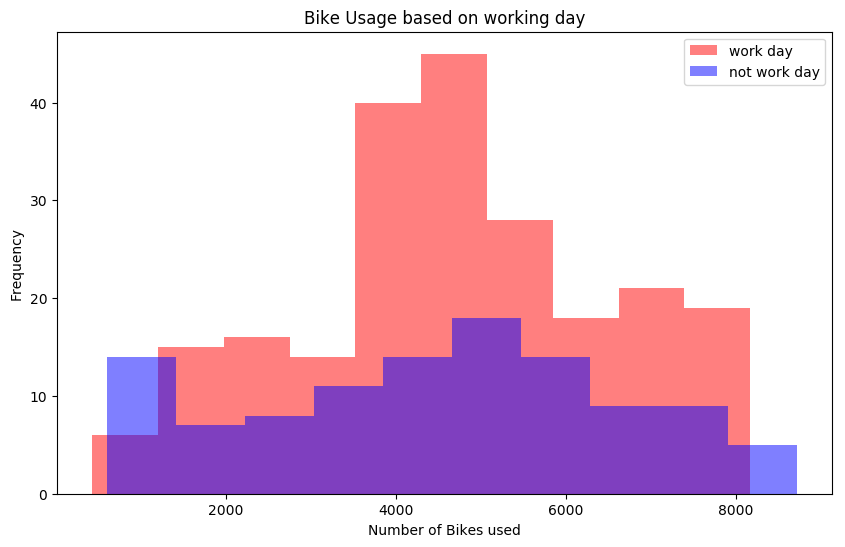

In [5]:
sns.reset_defaults()
plt.figure(figsize=(10, 6))
plt.hist(train[train['workingday'] == 1]['count'], color= 'red', alpha = .5, label= 'work day')
plt.hist(train[train['workingday'] == 0 ]['count'], color= 'blue', alpha = .5, label='not work day' )
plt.xlabel('Number of Bikes used')
plt.ylabel('Frequency')
plt.title('Bike Usage based on working day')
plt.legend()
plt.show()

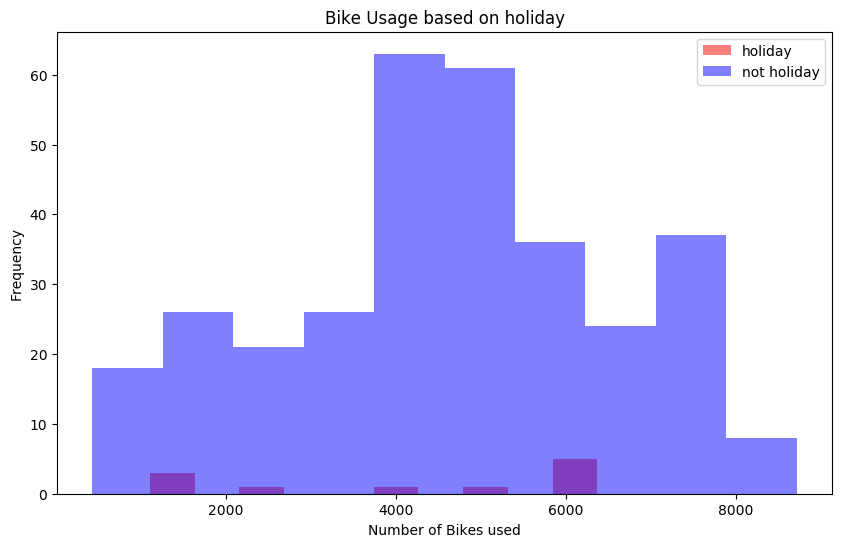

In [6]:
sns.reset_defaults()
plt.figure(figsize=(10, 6))
plt.hist(train[train['holiday'] == 1]['count'], color= 'red', alpha = .5, label= 'holiday')
plt.hist(train[train['holiday'] == 0 ]['count'], color= 'blue', alpha = .5, label='not holiday' )
plt.xlabel('Number of Bikes used')
plt.ylabel('Frequency')
plt.title('Bike Usage based on holiday')
plt.legend()
plt.show()

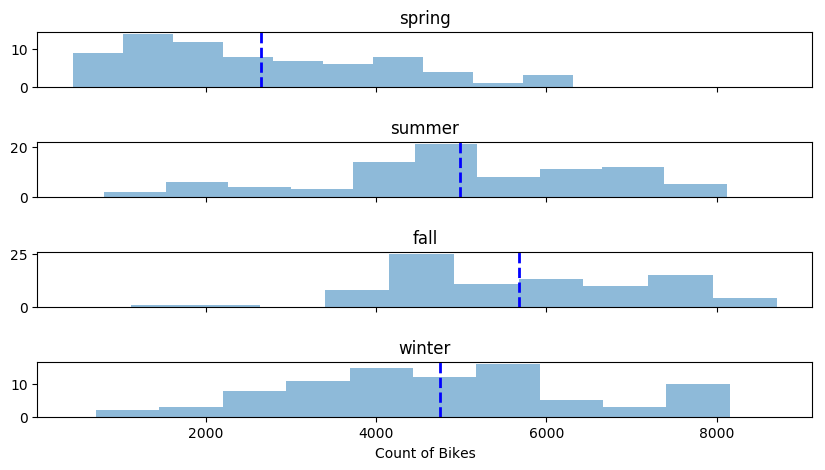

In [81]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, sharex=True, figsize = (10,5))
fig.subplots_adjust(hspace=1)
ax1.hist(train[train['season'] == 1]['count'], alpha = .5)
ax1.axvline(train[train['season'] == 1]['count'].mean(), color='b', linestyle='dashed', linewidth=2)
ax2.hist(train[train['season'] == 2 ]['count'], alpha = .5 )
ax2.axvline(train[train['season'] == 2]['count'].mean(), color='b', linestyle='dashed', linewidth=2)
ax3.hist(train[train['season'] == 3 ]['count'], alpha = .5)
ax3.axvline(train[train['season'] == 3]['count'].mean(), color='b', linestyle='dashed', linewidth=2)
ax4.hist(train[train['season'] == 4 ]['count'], alpha = .5 )
ax4.axvline(train[train['season'] == 4]['count'].mean(), color='b', linestyle='dashed', linewidth=2)
ax1.set_title('spring')
ax2.set_title('summer')
ax3.set_title('fall')
ax4.set_title('winter')
plt.xlabel('Count of Bikes')
plt.show()

We next require you to pre-process the categorical and numerical attributes in the data set:

- Notice that this data set contains categorical attributes with two or more categories. **Why can't they be directly used as predictors?** Convert these categorical attributes into multiple binary attributes using one-hot encoding: in the place of every categorical attribute $x_j$ that has categories $1, \ldots, K_j$, introduce $K_j-1$ binary predictors $x_{j1}, \ldots, x_{j,K_j-1}$ where $x_{jk}$ is 1 whenever $x_j = k$ and 0 otherwise. 
** Why is it okay to not have a binary column for the $K_j$-th category? **

- Since the attributes are in different scales, it is a good practice to standardize the continuous predictors, i.e. to scale each continuous predictor to have zero mean and a standard deviation of 1. This can be done by applying the following transform to each continuous-valued predictor $j$:
$\hat{x}_{ij} = (x_{ij} - \bar{x}_j) / s_j$, where $\bar{x}_j$ and $s_j$ are the sample mean and sample standard deviation (SD) of predictor $j$ in the training set. We emphasize that the mean and SD values used for standardization must be estimated using only the training set observations, while the transform is applied to both the training and test sets. 
** Why shouldn't we include the test set observations in computing the mean and SD? **

- Provide a table of the summary statistics of the new attributes (`pd.describe()' function will help).

*Hint:* You may use the `pd.get_dummies` function to convert a categorical attribute in a data frame to one-hot encoding. This function creates $K$ binary columns for an attribute with $K$ categories. We suggest that you delete the last (or first) binary column generated by this function.

**Note:** We shall use the term "attribute" to refer to a categorical column in the data set, and the term "predictor" to refer to the individual binary columns resulting out of one-hot encoding.

In [204]:
# list of all categorical variables and lables for them
cat_preds = ['season', 'month', 'day_of_week', 'weather']
labels = [['summer', 'fall', 'winter'],['Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul','Aug','Sep','Oct','Nov','Dec'], 
          ['mon', 'tue', 'wed','thu', 'fri','sat'], ['cloud', 'light']]

# loop through categorical variables and convert to one-hot encoding
for i,pred in enumerate(cat_preds): 
    dum = pd.get_dummies(train[pred])
    del dum [1]
    dum.columns = labels[i]
    train = train.join(dum)
    del train[pred]

# Repeat the same process for test data
for i,pred in enumerate(cat_preds): 
    dum = pd.get_dummies(test[pred])
    del dum [1]
    dum.columns = labels[i]
    test = test.join(dum)
    del test[pred]
    
# Mean and STD of continuous preidctors based on trainig set
temp_std = train['temp'].std(axis = 0)
temp_mean = train['temp'].mean(axis = 0)
atemp_std = train['atemp'].std(axis = 0)
atemp_mean = train['atemp'].mean(axis = 0)
humidity_std = train['humidity'].std(axis = 0)
humidity_mean = train['humidity'].mean(axis = 0)
wind_std = train['windspeed'].std(axis = 0)
wind_mean = train['windspeed'].mean(axis = 0)

# normalize training data
train['temp'] = (train['temp'] - temp_mean) / temp_std
train['atemp'] = (train['atemp'] - atemp_mean) / atemp_std
train['humidity'] = (train['humidity'] - humidity_mean) / humidity_std
train['windspeed'] = (train['windspeed'] - wind_mean) / wind_std
# normalize test data
test['temp'] = (test['temp'] - temp_mean) / temp_std
test['atemp'] = (test['atemp'] - atemp_mean) / atemp_std
test['humidity'] = (test['humidity'] - humidity_mean) / humidity_std
test['windspeed'] = (test['windspeed'] - wind_mean) / wind_std

In [205]:
train.describe()

,holiday,workingday,temp,atemp,humidity,windspeed,count,summer,fall,winter,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,mon,tue,wed,thu,fri,sat,cloud,light
count,331.000000,331.000000,3.310000e+02,3.310000e+02,3.310000e+02,3.310000e+02,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000
mean,0.033233,0.670695,-6.976628e-17,-1.227618e-16,-7.808457e-16,1.543579e-15,4598.447130,0.259819,0.265861,0.256798,0.066465,0.075529,0.078550,0.102719,0.072508,0.093656,0.081571,0.099698,0.090634,0.093656,0.066465,0.160121,0.135952,0.123867,0.123867,0.145015,0.135952,0.329305,0.030211
std,0.179515,0.470672,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1935.319338,0.439199,0.442459,0.437528,0.249471,0.264643,0.269442,0.304051,0.259719,0.291790,0.274124,0.300050,0.287523,0.291790,0.249471,0.367273,0.343256,0.329929,0.329929,0.352649,0.343256,0.470672,0.171428
min,0.000000,0.000000,-2.503291e+00,-2.572131e+00,-2.648736e+00,-2.152869e+00,431.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,-8.504011e-01,-8.603176e-01,-7.452412e-01,-7.381149e-01,3370.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,8.772587e-02,1.466312e-01,-6.562743e-03,-1.579037e-01,4648.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,8.024892e-01,7.508005e-01,7.055719e-01,5.693478e-01,5981.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.874634e+00,1.959139e+00,2.362380e+00,2.949989e+00,8714.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [206]:
test.describe()

,holiday,workingday,temp,atemp,humidity,windspeed,count,summer,fall,winter,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,mon,tue,wed,thu,fri,sat,cloud,light
count,400.00000,400.000000,400.000000,400.000000,400.000000,400.000000,400.00000,400.000000,400.000000,400.000000,400.00000,400.000000,400.000000,400.000000,400.00000,400.000000,400.00000,400.0000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.00000
mean,0.02500,0.695000,-0.128713,-0.121217,-0.076029,-0.008111,4514.21250,0.245000,0.250000,0.232500,0.08750,0.092500,0.085000,0.070000,0.09000,0.077500,0.08750,0.0675,0.080000,0.072500,0.100000,0.130000,0.147500,0.157500,0.157500,0.140000,0.150000,0.345000,0.02750
std,0.15632,0.460984,1.052309,1.061183,0.988182,0.983825,2092.60635,0.430626,0.433555,0.422955,0.28292,0.290093,0.279231,0.255467,0.28654,0.267718,0.28292,0.2512,0.271633,0.259639,0.300376,0.336725,0.355048,0.364728,0.364728,0.347422,0.357519,0.475964,0.16374
min,0.00000,0.000000,-2.324601,-2.370741,-4.421814,-1.858750,22.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,0.00000,0.000000,-1.073765,-1.061707,-0.879771,-0.714163,2875.25000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,0.00000,1.000000,-0.180310,-0.155453,-0.092312,-0.098286,4516.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
75%,0.00000,1.000000,0.802489,0.851495,0.665606,0.534842,6174.75000,0.000000,0.250000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.00000
max,1.00000,1.000000,1.963980,2.261224,2.202511,4.046877,10045.00000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.00000,1.000000,1.00000,1.0000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000


## Part (b): Multiple Linear Regression

We are now ready to fit a linear regression model and analyze its coefficients and residuals.

- Fit a multiple linear regression model to the training set, and report its $R^2$ score on the test set.
- *Statistical significance*: Using a t-test, find out which of estimated coefficients are statistically significant at a significance level of 5% (p-value<0.05). Based on the results of the test, answer the following questions:
    - Which among the predictors have a positive correlation with the number of bike rentals? 
    - Does the day of a week have a relationship with bike rentals? 
    - Does the month influence the bike rentals? 
    - What effect does a holiday have on  bike rentals? 
    - Is there a difference in the coefficients assigned to `temp` and `atemp`? Give an explanation for your observation.
- *Residual plot:* Make a plot of residuals of the fitted model ${e} = y - \hat{y}$ as a function of the predicted value $\hat{y}$. Note that this is different from the residual plot for simple linear regression. Draw a horizontal line denoting the zero residual value on the Y-axis. Does the plot reveal a non-linear relationship between the predictors and response? What does the plot convey about the variance of the error terms?


In [217]:
X = 0
y = train['count']
x = list(train.columns)
x.remove('count')
X = train[x]
X = sm.add_constant(X)
X_test = test[x]
X_test = sm.add_constant(X_test)
model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  count   R-squared:                       0.576
Model:                            OLS   Adj. R-squared:                  0.538
Method:                 Least Squares   F-statistic:                     15.25
Date:                Wed, 04 Oct 2017   Prob (F-statistic):           6.56e-42
Time:                        14:52:30   Log-Likelihood:                -2832.1
No. Observations:                 331   AIC:                             5720.
Df Residuals:                     303   BIC:                             5827.
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2993.7090    323.116      9.265      0.000    2357.874    3629.544
holiday      279.9598    330.470      0.847      0.398    -370.346     930.266
workingday   872.4692    202.510      4.308      0.000     473.965    1270.973
temp         925.7338    474.536      1.951      0.052      -8.070    1859.538
atemp        312.4341    429.987      0.727      0.468    -533.705    1158.573
humidity    -548.4929    113.200     -4.845      0.000    -771.251    -325.735
windspeed   -255.1226     80.766     -3.159      0.002    -414.057     -96.189
summer       898.8290    487.802      1.843      0.066     -61.079    1858.737
fall        1032.8816    567.827      1.819      0.070     -84.503    2150.266
winter      1226.1865    506.763      2.420      0.016     228.966    2223.407
Feb           88.9401    397.048      0.224      0.823    -692.381     870.262
Mar          239.1809    446.873      0.535      0.593    -640.188    1118.549
Apr          333.3491    675.444      0.494      0.622    -995.806    1662.504
May          -65.8125    726.311     -0.091      0.928   -1495.065    1363.440
Jun         -792.2629    749.803     -1.057      0.292   -2267.744     683.218
Jul        -1279.9870    816.047     -1.569      0.118   -2885.824     325.850
Aug         -776.4755    794.782     -0.977      0.329   -2340.467     787.516
Sep          405.1446    694.714      0.583      0.560    -961.931    1772.220
Oct          486.2509    651.713      0.746      0.456    -796.206    1768.708
Nov          112.6816    621.610      0.181      0.856   -1110.538    1335.902
Dec         -118.8358    505.353     -0.235      0.814   -1113.282     875.611
mon          688.0675    196.838      3.496      0.001     300.724    1075.411
tue          -71.5345    282.049     -0.254      0.800    -626.557     483.488
wed          294.2628    288.975      1.018      0.309    -274.390     862.916
thu          185.0075    282.022      0.656      0.512    -369.962     739.977
fri          234.8184    275.626      0.852      0.395    -307.565     777.202
sat         1153.2125    211.048      5.464      0.000     737.907    1568.518
cloud        -16.5666    210.139     -0.079      0.937    -430.083     396.949
light      -1581.9783    529.223     -2.989      0.003   -2623.396    -540.560
==============================================================================
Omnibus:                       28.947   Durbin-Watson:                   1.912
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                9.753
Skew:                           0.054   Prob(JB):                      0.00762
Kurtosis:                       2.166   Cond. No.                     2.34e+15
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is

In [219]:
r2_test = r2_score(y_true=test['count'], y_pred= model.predict(X_test))
print('R^2 score on test set = %f'%r2_test)

R^2 score on test set = 0.249342


In [241]:
# Extract all coeficients with p values below .05 and print them
print(list(model.pvalues[model.pvalues < .05].axes[0]))
print('^ List of statistically significant coefficients according to t-test at a=.05 level')

['const', 'workingday', 'humidity', 'windspeed', 'winter', 'mon', 'sat', 'light']
^ List of statistically significant coefficients according to t-test at a=.05 level


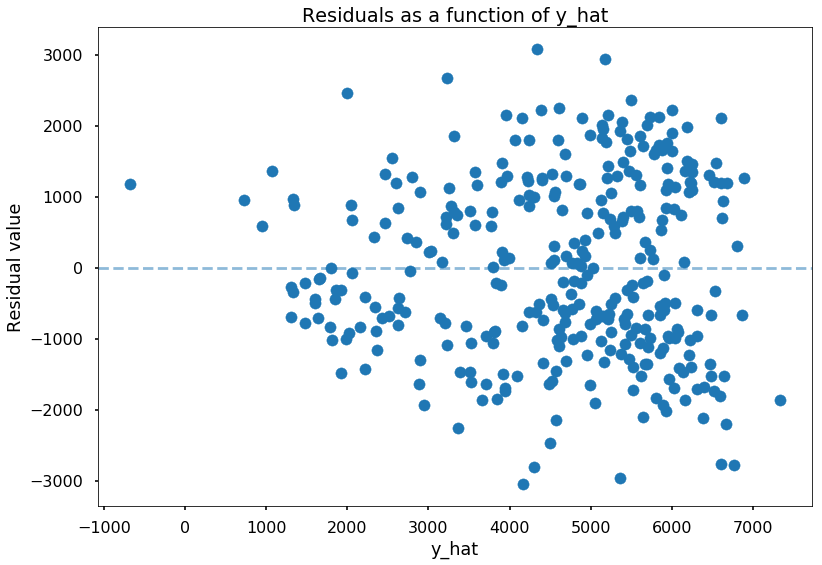

In [263]:
e = y - model.predict()
plt.scatter(model.predict(), e)
plt.title('Residuals as a function of y_hat')
plt.ylabel('Residual value')
plt.xlabel('y_hat')
plt.axhline(linestyle = "--", alpha = .5)
plt.show()

## Part (c): Checking Collinearity

Does the data suffer from multi-collinearity? To answer this question, let us first analyze the correlation matrix for the data. Compute the (Pearson product-moment) correlation matrix for the predictor variables in the training set, and visualize the matrix using a heatmap. For categorical attributes, you should use each binary predictor resulting from one-hot encoding to compute their correlations.  Are there predictors that fall into natural groups based on the correlation values? 

*Hint:* You may use the `np.corrcoef` function to compute the correlation matrix for a data set (do not forget to transpose the data matrix). You may use `plt.pcolor` function to visualize the correlation matrix.

In [13]:
# your code here

your answers here

## Part (d): Subset Selection

Apply either one of the following subset selection methods discussed in class to choose a minimal subset of predictors that are related to the response variable:
- Step-wise forward selection
- Step-wise backward selection

We require you to implement both these methods *from scratch*. You may use the Bayesian Information Criterion (BIC) to choose the subset size in each method. Do these methods eliminate one or more of the redundant predictors (if any) identified in Part (c)? In each case, fit linear regression models using the identified subset of predictors to the training set. How do the test $R^2$ scores for the fitted models compare with the model fitted in Part (b) using all predictors?




In [15]:
# your code here

your answers here

## Part (e): Cross Validation

- Perform a 10-fold cross-validation procedure to select between the 3 competing models you have so far: the model with the best BIC from Step-wise forward selection, the model with the best BIC from Step-wise backward selection (if it is different), and the model with all possible predictors.  Report the average $R^2$ across all 10 validation sets for each model and compare the results.  Why do you think this is the case?
- Evaluate each of the 3 models on the provided left out test set by calculating $R^2$.  Do the results agree with the cross-validation?  Why or why not?

In [8]:
# your code here

your answers here